# sklearn-LDA

代码示例：https://mp.weixin.qq.com/s/hMcJtB3Lss1NBalXRTGZlQ （玉树芝兰） <br>
可视化：https://blog.csdn.net/qq_39496504/article/details/107125284  <br>
sklearn lda参数解读:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
<br>中文版参数解读：https://blog.csdn.net/TiffanyRabbit/article/details/76445909
<br>LDA原理-视频版：https://www.bilibili.com/video/BV1t54y127U8
<br>LDA原理-文字版：https://www.jianshu.com/p/5c510694c07e
<br>score的计算方法：https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/sklearn/decomposition/_lda.py#L729
<br>主题困惑度1：https://blog.csdn.net/weixin_43343486/article/details/109255165
<br>主题困惑度2：https://blog.csdn.net/weixin_39676021/article/details/112187210

## 1.预处理

In [1]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [20]:
output_path = 'D:/lda/result'
file_path = 'D:/lda/data'
os.chdir(file_path)
data=pd.read_excel("爆发期.xlsx")#content type
os.chdir(output_path)
dic_file = "D:/lda/stop_dic/dict.txt"
stop_file = "D:/lda/stop_dic/stopwords.txt"
synonym_file = "D:/lda/stop_dic/synonym_list.xlsx"  #放置同义词excel文件
synonym_words = pd.read_excel(synonym_file)
synonym_origin = list(synonym_words['origin'])
synonym_new = list(synonym_words['new'])

In [21]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        #word = seg_word.word  #如果想要分析英语文本，注释这行代码，启动下行代码
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            if word in synonym_origin:
                index = synonym_origin.index(word)
                word = synonym_new[index]
            word_list.append(word) 
    return (" ").join(word_list)

In [22]:
data=data.astype(str)
data["content_cutted"] = data.content.apply(chinese_word_cut)

## 2.LDA分析

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [24]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [25]:
n_features = 10000 #提取n个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,  #忽略出现在50%以上文本中的词
                                min_df = 2)    #忽略出现次数小于2的词（这两处的数字：0.x为x%，整数为出现次数）
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [38]:
n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
                                 doc_topic_prior=0.2,
                                 topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.2, learning_offset=50, max_iter=50,
                          n_components=6, random_state=0,
                          topic_word_prior=0.01)

### 2.1输出每个主题对应词语 

In [39]:
n_top_words = 15
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
染指 全国 服装 民族服饰 人民 比赛 服装秀 吹牛 民众 自豪 清华 商机 赛事 视频 精神
Topic #1:
足球 国家 净土 球队 民间 联赛 农村 踢足球 职业 差距 业余 凉水 村队 球员 水平
Topic #2:
国足 世界杯 资本 活动 污染 建议 兄弟姐妹 球员 服饰 足球宝贝 指导 兄弟 代表 层层 成绩
Topic #3:
文化 体育 发展 运动 特色 魅力 领导 专业 味道 中华民族 利益 人人 全民 娱乐 传统
Topic #4:
海参 民族 民族特色 回家 生活 家乡 免费 精彩 朋友 民间 官方 体育精神 队员 体育赛事 合规
Topic #5:
汉族 民族 世界 调研 少数民族 特长 名族 踢球 孩子 地方 服饰 衣服 汉族人 特色 才艺


### 2.2输出每篇文章对应主题 

In [40]:
import numpy as np

In [41]:
topics=lda.transform(tf)

In [42]:
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_excel("爆发期data_topic.xlsx",index=False)

### 2.3可视化 

In [43]:
import pyLDAvis
import pyLDAvis.sklearn

In [44]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, '爆发期lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)
#去工作路径下找保存好的html文件

### 2.4困惑度 

In [33]:
import matplotlib.pyplot as plt

In [34]:
plexs = []
scores = []
n_max_topics = 11
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10


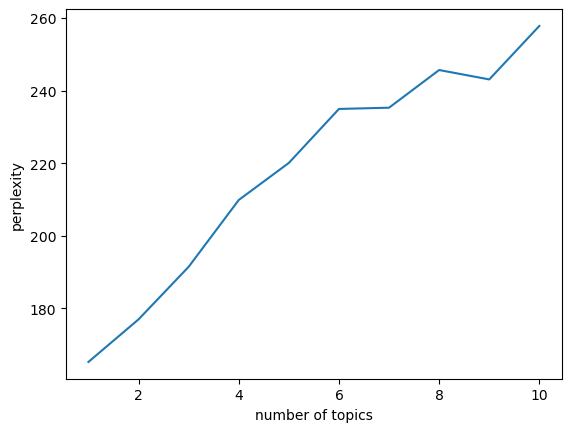

In [35]:
n_t=10#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.savefig('爆发期困惑度')
plt.show()